# Индикаторы оттока клиентов фитнес-центра

## Содержание: <a name="content"></a>
- [Загрузка и просмотр данных, импорт библиотек](#loading)
- [Исследовательский анализ данных (EDA)](#eda)
- [Модель прогнозирования оттока пользователей](#forecasting_model)
- [Кластеризация пользователей](#clusterization_of_users)
- [Общие выводы](#results)

### Импорт библиотек

In [1]:
# Загружаем необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Загрузка и просмотр данных <a name="loading"></a>

[к содержанию](#content)

Загрузим таблицу gym_churn и посмотрим информацию по ней:

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# Приведем названия столбцов к нижнему регистру:
gym.columns = gym.columns.str.lower()

In [5]:
gym.shape

(4000, 14)

In [6]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [7]:
gym.duplicated().sum()

0

**Вывод:** 
В таблице gym содержатся данные на месяц до оттока и факт оттока на определённый месяц.
Таблица состоит из 14 столбцов и 4 000 строк. 

Пропусков и дубликатов в данных нет, все признаки числовые.
Изменили названия столбцов - привели к нижнему регистру

## Исследовательский анализ данных (EDA) <a name="eda"></a>

[к содержанию](#content)

Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения. Используем метод describe()

In [8]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [9]:
# Рассмотрим средние критериев по целевому показателю:
df = gym.groupby(['churn'])[gym.drop('churn', axis=1).columns].mean()
df

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [10]:
df.shape

(2, 13)

Здесь мы видим существенную разницу по всем стобцам, кроме пола и данных телефона.

In [11]:
# Построим функцию для рассмотрения распределений: 
def func_draw(df):
    scaler = StandardScaler() # создаём объект класса scaler (стандартизатор)
    scaler.fit(df) # обучаем стандартизатор
    X_sc = scaler.transform(df) # преобразуем набор данных
    df_new = pd.DataFrame(data = X_sc, columns = [df.columns.tolist()])
    for feature in df_new.columns:
        sns.distplot(df_new[feature ], bins = 10)
        plt.title(feature)
        plt.show()

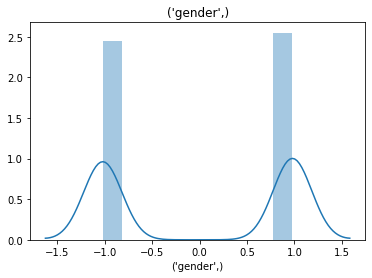

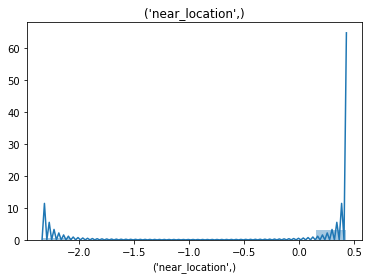

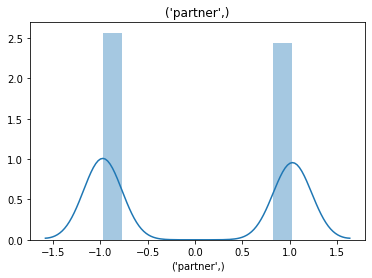

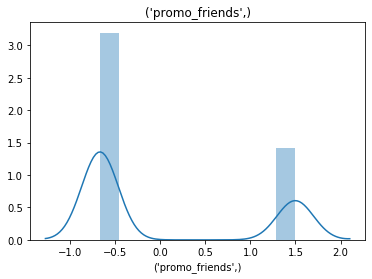

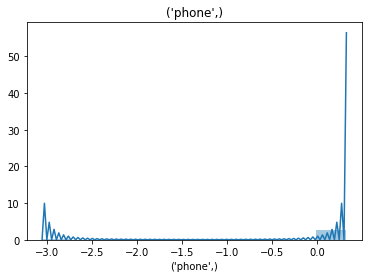

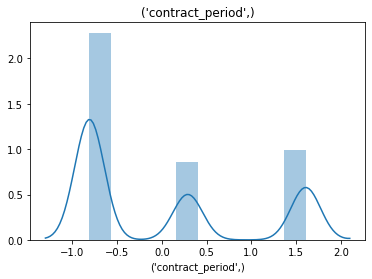

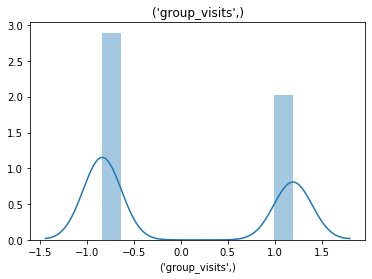

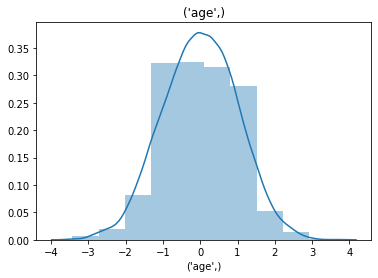

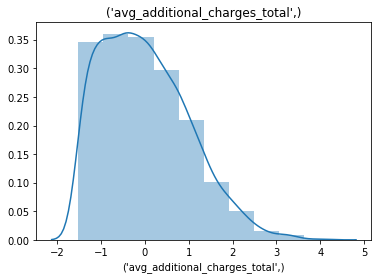

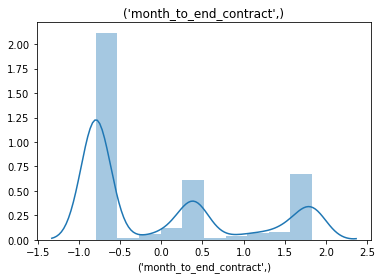

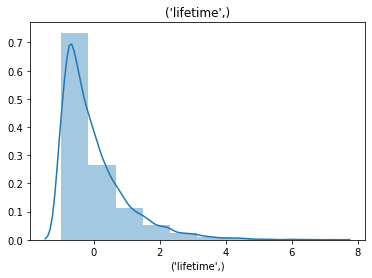

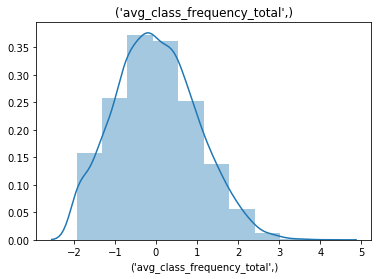

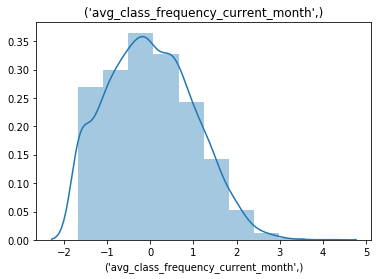

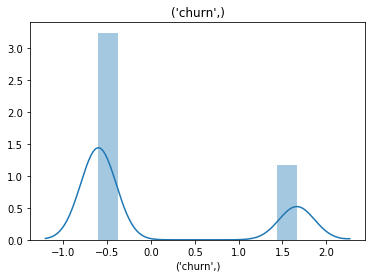

In [12]:
# Посмотрим на общие распределения:
func_draw(gym)

Распределенные критерии имееют выраженное смещение влево, кроме возраста. Категориальные признаки имеют равное распределение по полу и партнерам, остальные также имеют смещение. Целевой показатель не сбалансирован

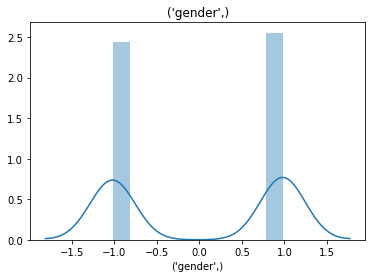

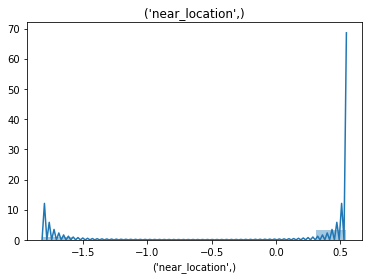

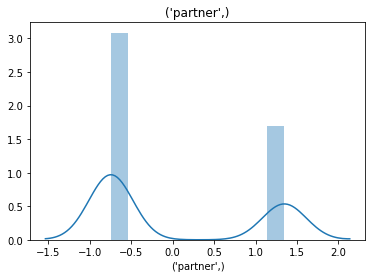

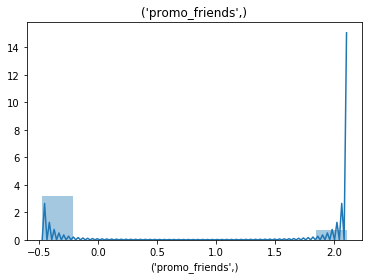

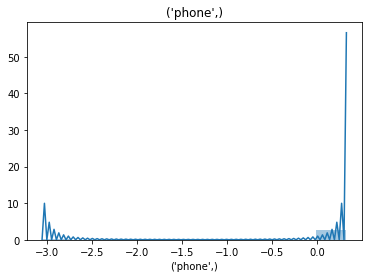

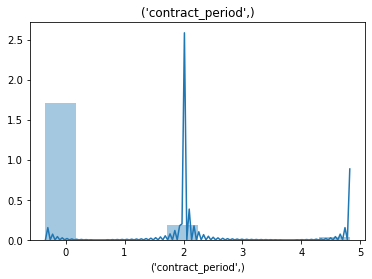

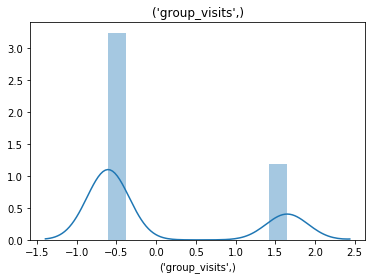

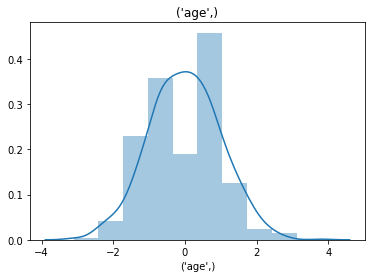

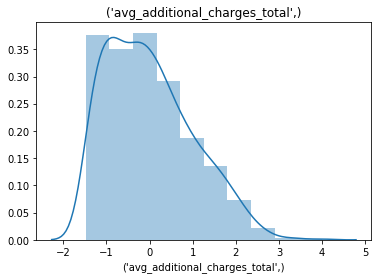

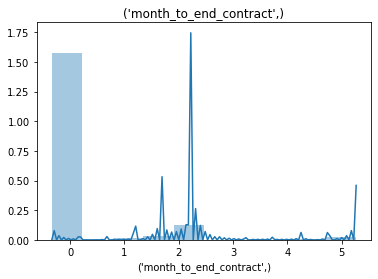

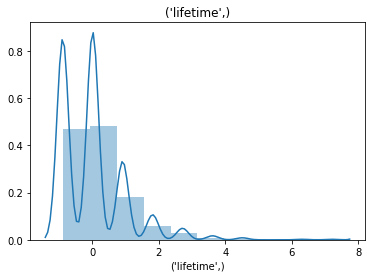

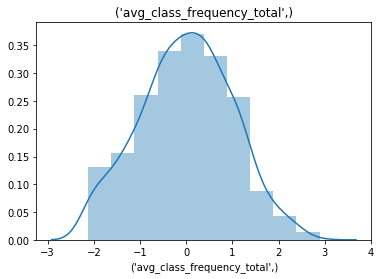

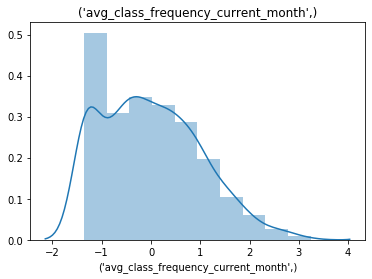

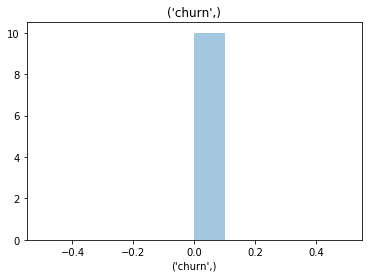

In [12]:
# Рассмотрим распределеия churn = 1:
df = gym.query('churn == 1')
func_draw(df)

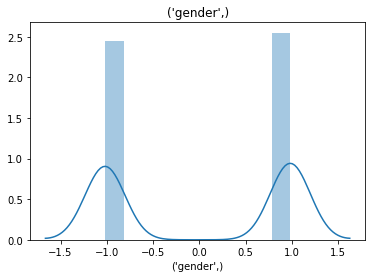

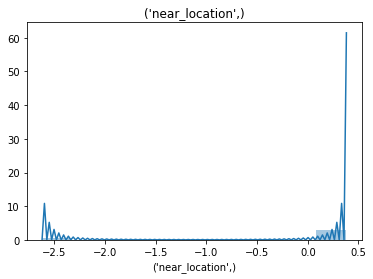

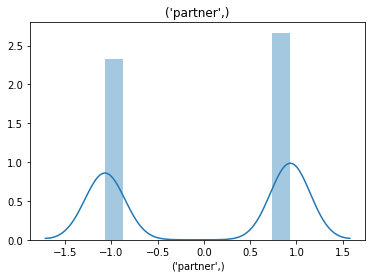

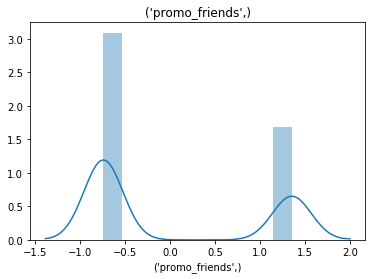

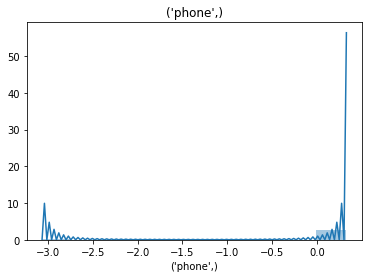

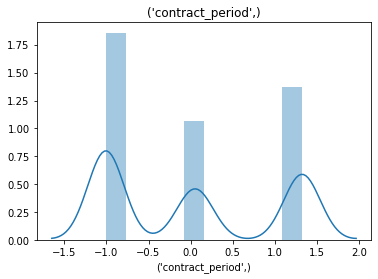

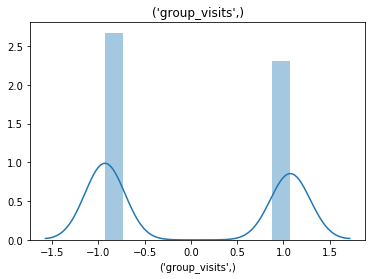

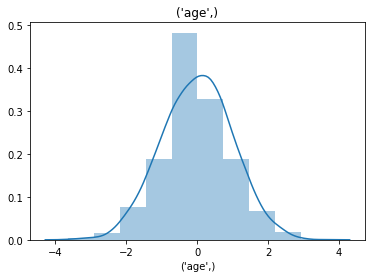

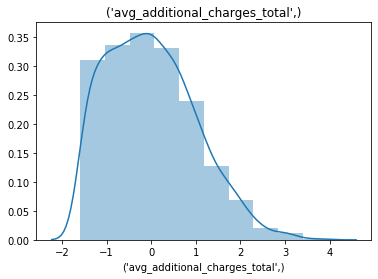

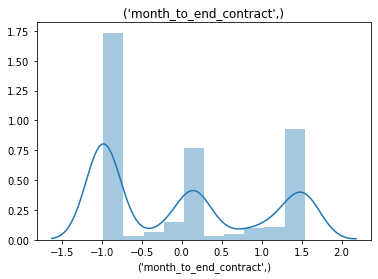

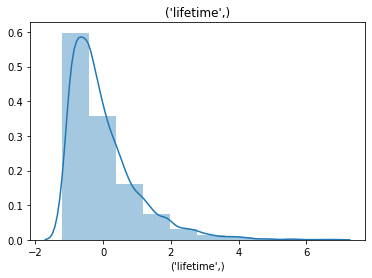

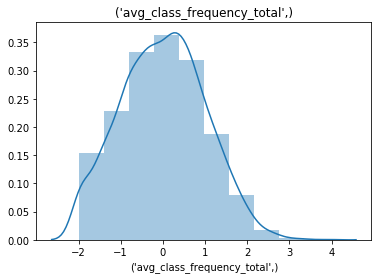

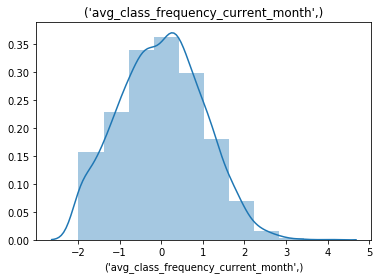

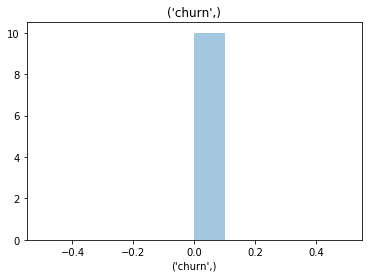

In [13]:
# рассмотрим распределеия churn = 0
df = gym.query('churn == 0')
func_draw(df)

In [14]:
# Создадим словарь признков:
columns = gym.drop('churn', axis=1).columns.tolist()
# и сделаем функцию отрисовки графиков:
def func_pairdraw(column):
    sns.distplot(gym[gym['churn']==0][column], kde=False, norm_hist=True, bins = range(13), label='0')
    sns.distplot(gym[gym['churn']==1][column], kde=False, norm_hist=True, bins = range(13), label='1')
    plt.legend()
    plt.show()

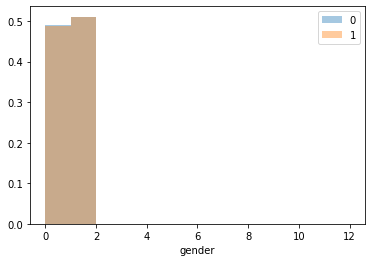

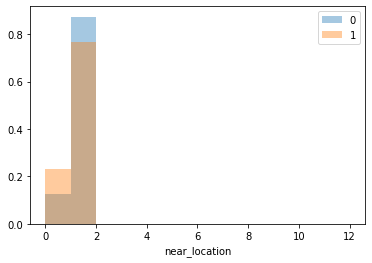

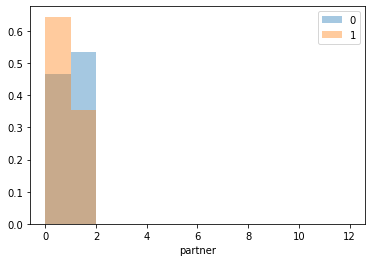

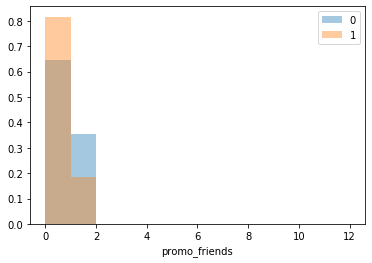

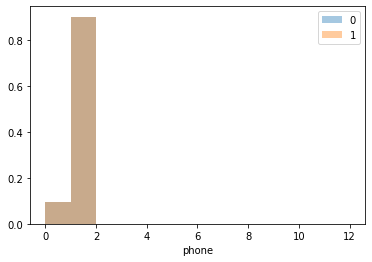

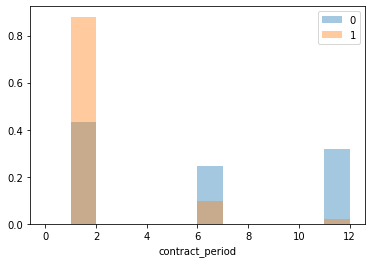

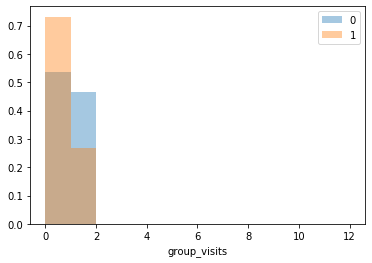

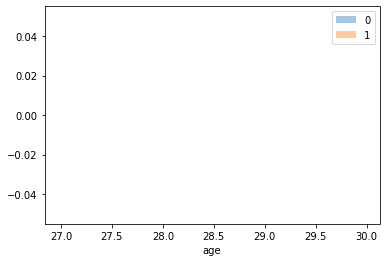

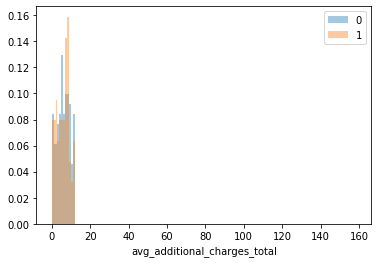

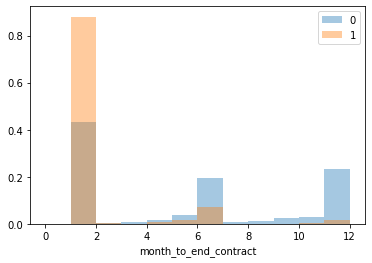

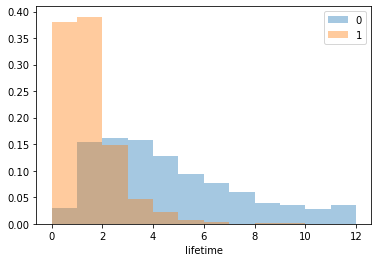

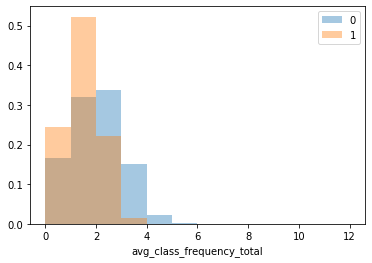

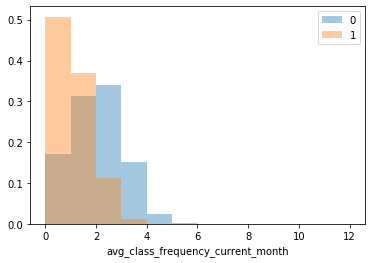

In [15]:
# Сделаем сравнение показателй к разному целевому признаку на графиках
for column in columns:
    func_pairdraw(column)

При рассмотрении по целевому показателю мы имеем смещение распределений вправо. Отметим прямую зависимость остатков месяцев посещения, длинны контракта, наличия трудоустройства у партнеров, доп. трат, срок до окончания абонемента

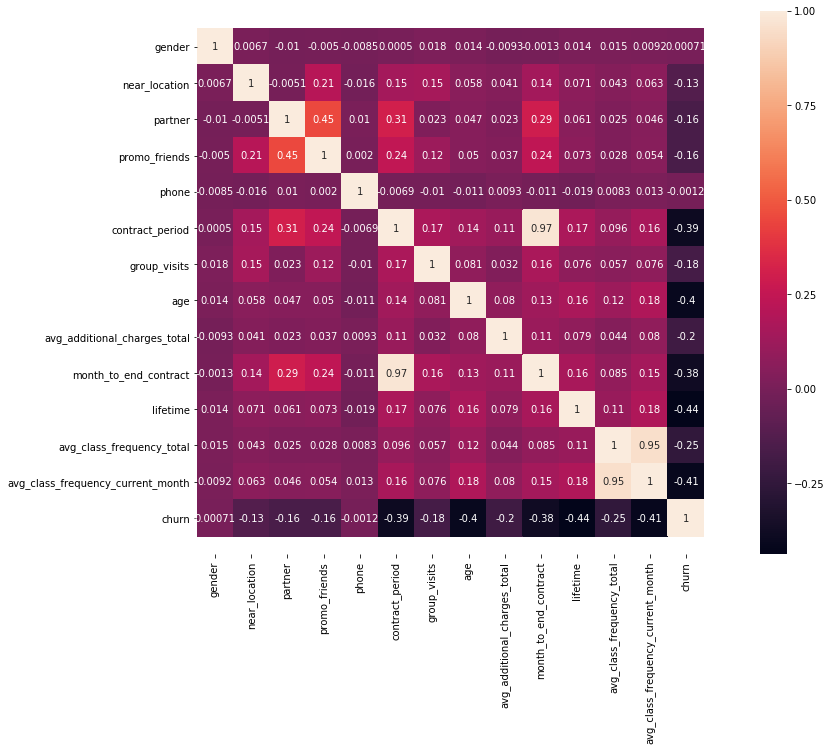

In [16]:
# Расчитаем матрицу корреляций:
cm = gym.corr() 
plt.figure(figsize=(20,10))
ax = sns.heatmap(cm, annot = True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Мы видим сильную корреляцию между сроком абонемента и остатком.
А также по посещениям за год и пред. месяц.
С целевой переменной все признаки имеют отрицательную корреляцию, в абсолютных значениях к значениям 0,44 приблизились возраст и срок абонемента

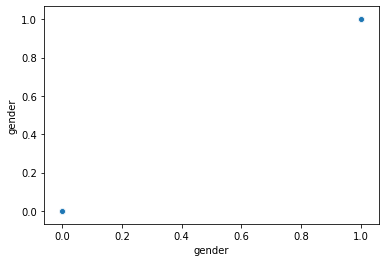

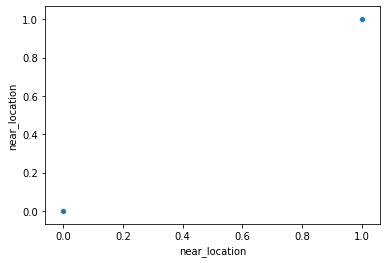

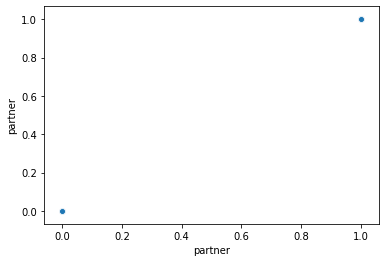

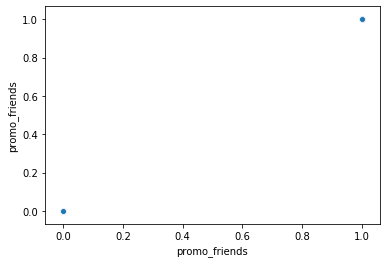

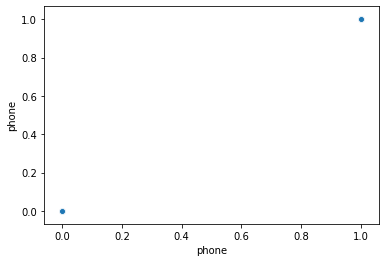

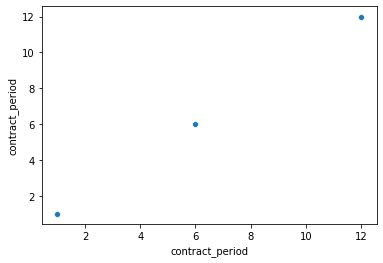

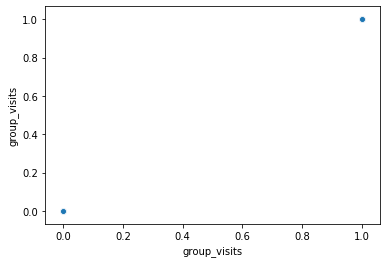

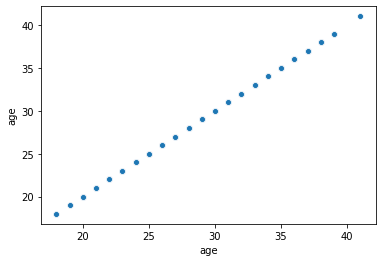

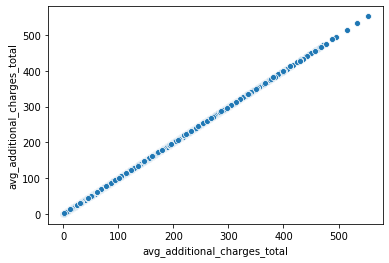

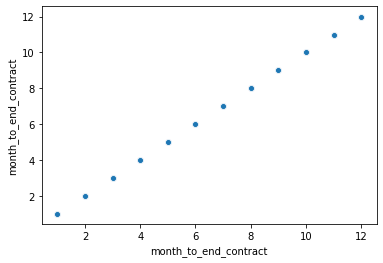

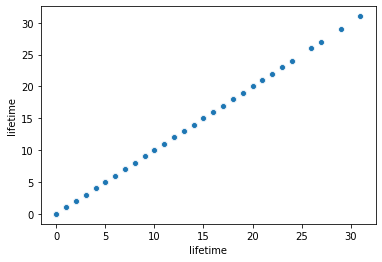

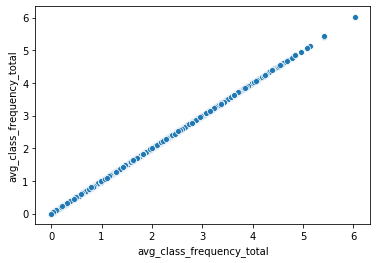

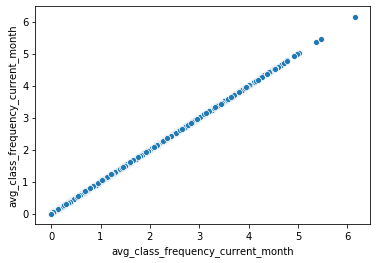

In [17]:
# Построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака:
for col in gym.drop('churn', axis=1).columns:
    sns.scatterplot(gym[col], gym[col])
    plt.show()

Наибольшее распределние значений признаков, исходя из корреляции могут быть:
- Avg_class_frequency_total
- Avg_class_frequency_current_month (что-то одно, тк они сильно коррелируют между собой
- lifetime
- Avg_additional_charges_total

## Модель прогнозирования оттока пользователей <a name="forecasting_model"></a>

[к содержанию](#content)

In [18]:
# Разделим данные на признаки (матрица X) и целевую переменную (y):
X = gym.drop('churn', axis=1)
y = gym['churn']

In [19]:
# Теперь разделим модель на обучающую и валидационную выборку:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
# Создадим объект класса StandardScaler и применим его к обучающей выборке:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
# применяем стандартизацию к матрице признаков для тестовой выборки:
X_test_st = scaler.transform(X_test)

In [21]:
# Определим функцию, которая будет выводить метрики:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [22]:
# Зададим алгоритм для модели логистической регрессии:
lr_model = LogisticRegression()
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# выведем все метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [23]:
# Зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]# Ваш код здесь
# выведем все метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities,  title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


На основании полученных метрик мы видим одинаковую долю правильныхз ответов у каждой модели, также у логистической регресии выше точность и, наиболее важое в нашем случае, полнота

## Кластеризация пользователей <a name="clusterization_of_users"></a>

[к содержанию](#content)

In [24]:
# Стандартизируем данные перед работой с алгоритмами:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

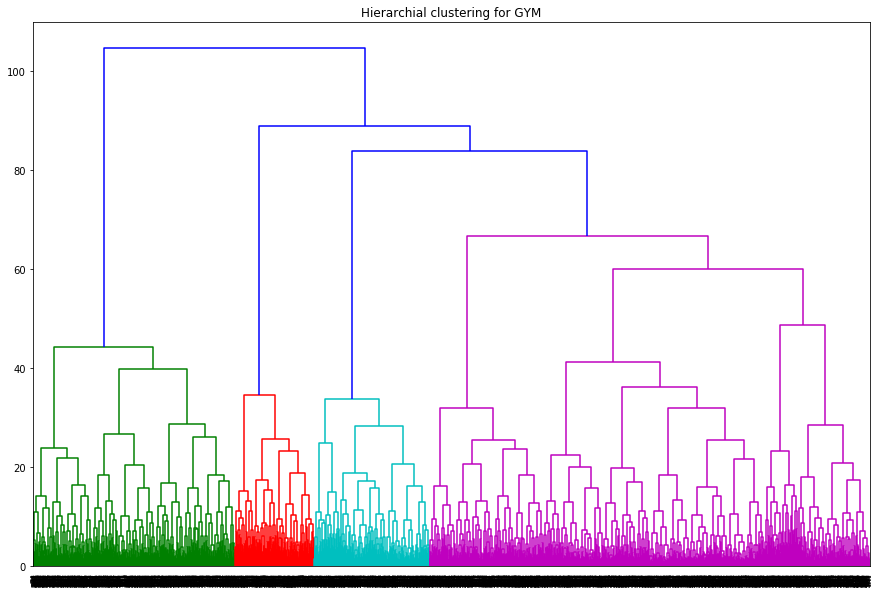

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Можем выделить от 2 и более кластеров. В целом, по дендрограмме можно выделить 4-6 кластеров

In [26]:
# Задаём модель k_means с числом кластеров 5:
km =  KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
gym['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
gym.groupby(['cluster_km']).mean().sort_values('churn').reset_index()

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100
2,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
3,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
4,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263


In [27]:
# Построим функцию гистограммы распределений критериев по кластерам:
def func_cluster(column):
    sns.distplot(gym[gym['cluster_km']==0][column], kde=False, norm_hist=True, bins = range(13), label='0')
    sns.distplot(gym[gym['cluster_km']==1][column], kde=False, norm_hist=True, bins = range(13), label='1')
    sns.distplot(gym[gym['cluster_km']==2][column], kde=False, norm_hist=True, bins = range(13), label='2')
    sns.distplot(gym[gym['cluster_km']==3][column], kde=False, norm_hist=True, bins = range(13), label='3')
    sns.distplot(gym[gym['cluster_km']==4][column], kde=False, norm_hist=True, bins = range(13), label='4')
    plt.legend()
    plt.show()

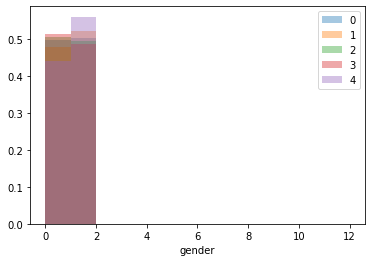

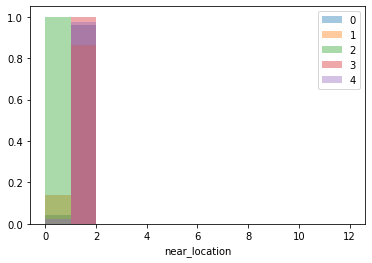

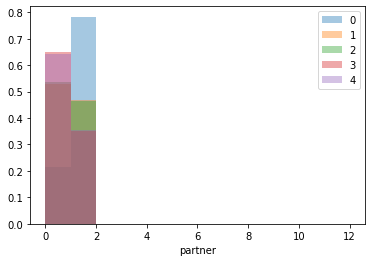

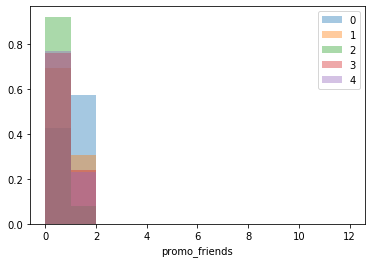

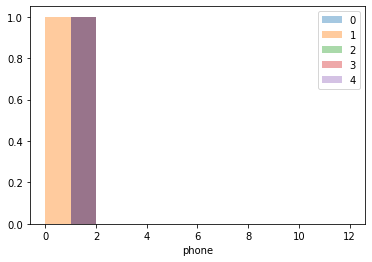

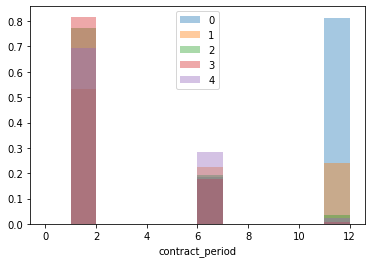

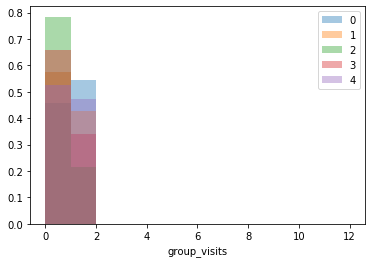

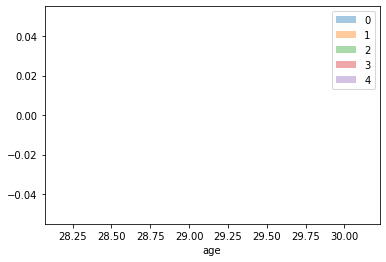

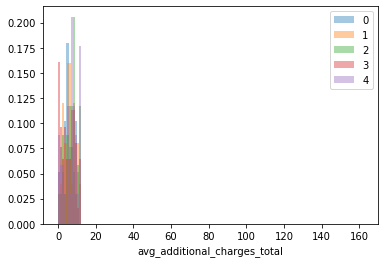

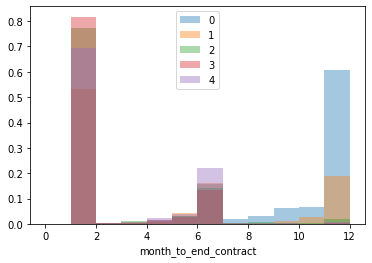

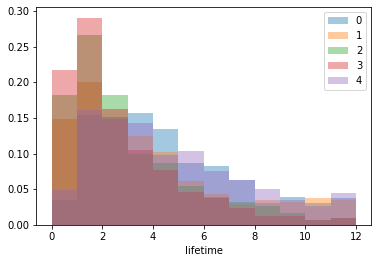

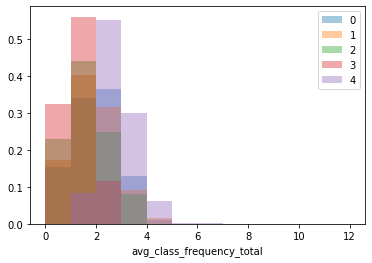

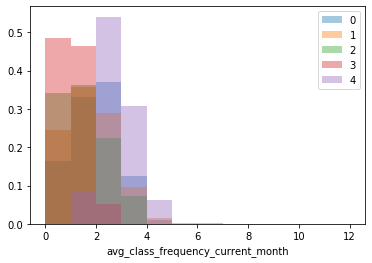

In [28]:
# Построим гистограммы распределений критериев по кластерам:
for column in columns:
    func_cluster(column)

На основании распределения значений показателей по кластерам можем сделать следующие выводы:
- пол, возраст и близость от клуба не влияют на отток

Реже уходит:
- сотрудник компании-партнёра клуба 
- тот кто пришел по промо от друга
- тот кто имеет долгий абонемент
- кто чаще посещает групповые занятия
- кто больше тратит дополнительно
- у кого больше неиспользованных месяцев по абонементу
- кто ходит больше раза в неделю

In [29]:
# Посчитаем всего клиентов по кластерам:
df = gym.groupby(['cluster_km']).agg({'churn':'count'}).reset_index().sort_values('churn').rename(columns = {'churn': 'count'})
df

,cluster_km,count
1,1,385
2,2,505
4,4,837
0,0,1011
3,3,1262


In [30]:
# Посчитаем клиентов со значеним оттока 1:
df1 = gym.query('churn == 1').groupby(['cluster_km']).agg({'churn':'count'}).reset_index().sort_values('churn')
df1

,cluster_km,churn
0,0,28
4,4,57
1,1,103
2,2,224
3,3,649


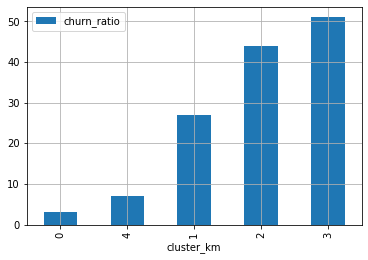

In [31]:
# Посчитаем процент ухода по кластерам и выведем диаграмму:
df['churn_ratio'] = (df1['churn']/df['count']).round(2)*100
df.sort_values('churn_ratio').plot(x = 'cluster_km', y = 'churn_ratio', kind = 'bar', grid = True)
plt.show()

**Самый большой отток в 3 кластере, самый малый в 0.**

## Общие выводы <a name="results"></a>

[к содержанию](#content)

Базовые рекомендации по работе с клиентами:
1. Активно наращивать компании-партнёры клуба
2. Проводить промо-акции 'приведи друга'
3. Мотивировать на более длительный контракты
4. Отслеживать посещения групповых занятий, при снижении показателя менее 0,5, клиент готов уйти
5. Предоставлять условия для доп. трат в виде сопутствующих товаров и услуг
6. При снижении частоты посещений до 1 раза в неделю рассылать мотивирующие предложения

<div class="alert alert-block alert-success">
Итог ревью - ты проделал хорошую работу, по всем пунктам получены корректные результаты. Понравилась структура твоей работы - было легко проверять. Отмечу наглядные и правильно оформленные графики и наличие выводов по каждому этапу. Так держать! Успехов в дальнейшем обучении
</div>
    
---